In [1]:
import numpy as np
import matplotlib.pyplot as plt

from dbqite_theory_sim import (
    simulate_dbqite_single_qubit,
    make_H,
    ground_state,
    hamiltonian_axis,
    bloch_vector,
)

In [ ]:
# ============================================================
# Global configuration: adjust to match your hardware settings
# ============================================================

# Hamiltonian A (larger gap)
DELTA_A = 1.0    # Δ_A
OMEGA_A = 0.7    # Ω_A

# Hamiltonian B (smaller gap)
DELTA_B = 0.4    # Δ_B
OMEGA_B = 0.2    # Ω_B

# Step size for gap-dependence and convergence plots
S_GAP = 0.05
S_CONV = 0.05

# Number of DB-QITE steps for convergence curves
N_STEPS_CONV = 5

# Warm-start rotation angle (defines psi0_warm = R_y(theta_warm)|0>)
THETA_WARM = np.pi / 4.0  # adjust to match your prepared warm state

# Initial-state angle for gap and step-size scans
THETA_INIT = np.pi / 4.0  # same or different from THETA_WARM if you like

# Theta range for initial-fidelity scan
THETA_MIN = 0.0
THETA_MAX = np.pi
N_THETA_POINTS = 25

# DB-QITE method: "GC" or "HOPF"
DBQITE_METHOD = "GC"

# Initial state |0>
psi_zero = np.array([1.0, 0.0], dtype=complex)

### Figure 1: Fidelity Gain vs Spectral Gap

We compare DB-QITE performance on two Hamiltonians with different spectral gaps:

| Hamiltonian | $\Delta$ | $\Omega$ | Gap |
|-------------|----------|----------|-----|
| A | 1.0 | 0.7 | $2\sqrt{\Delta^2 + \Omega^2}$ |
| B | 0.4 | 0.2 | (smaller) |

**Protocol:**
1. Prepare initial state with fixed fidelity $F_0 = 0.1$
2. Apply one DB-QITE step with $s = \Delta_{\text{gap}} / (12 H_{\text{norm}}^3)$
3. Measure fidelity gain $\Delta F = F_1 - F_0$

**Expected result:** Larger spectral gap → faster cooling → larger $\Delta F$

In [ ]:
def Ry(theta):
    """
    Single-qubit Y rotation:
        R_y(theta) = exp(-i theta Y / 2)
    in the {|0>, |1>} basis.
    """
    c = np.cos(theta / 2.0)
    s = np.sin(theta / 2.0)
    return np.array([[c, -s],
                     [s,  c]], dtype=complex)

In [4]:
def H_norm_single_qubit(Delta, Omega):
    return 0.5 * np.sqrt(Delta**2 + Omega**2)

Hnorm_A = H_norm_single_qubit(DELTA_A, OMEGA_A)
Hnorm_B = H_norm_single_qubit(DELTA_B, OMEGA_B)

print("Hnorm_A =", Hnorm_A)
print("Hnorm_B =", Hnorm_B)

Hnorm_A = 0.6103277807866851
Hnorm_B = 0.223606797749979


In [ ]:
def make_psi0_with_fixed_F0(Delta, Omega, F0_target, phase=0.0):
    H = make_H(Delta, Omega)
    evals, evecs = np.linalg.eigh(H)
    gs = evecs[:, np.argmin(evals)]
    es = evecs[:, np.argmax(evals)] 

    psi0 = np.sqrt(F0_target) * gs + np.exp(1j*phase) * np.sqrt(1 - F0_target) * es
    psi0 = psi0 / np.linalg.norm(psi0)
    return psi0


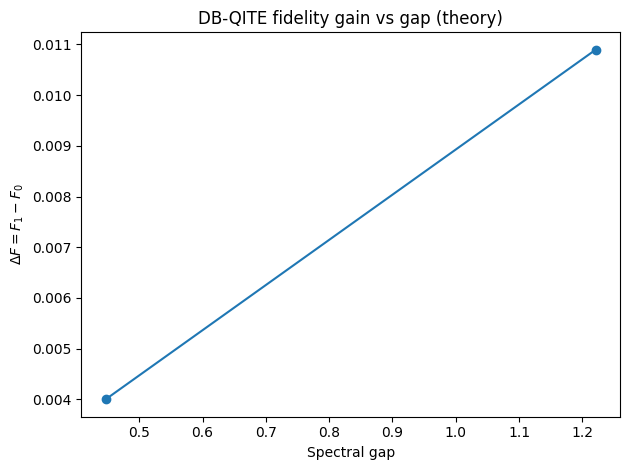

In [12]:
F0_target = 0.1
psi0_A = make_psi0_with_fixed_F0(DELTA_A, OMEGA_A, F0_target)
s_list = [S_GAP]
# H_A
gap_A, _ = hamiltonian_axis(DELTA_A, OMEGA_A)
s_A = gap_A / (12 * (Hnorm_A**3))
Es_A, Vs_A, Fs_A, _ = simulate_dbqite_single_qubit(
    DELTA_A, OMEGA_A, s_list, psi0_A,
    method=DBQITE_METHOD, return_states=True
)
deltaF_A = Fs_A[1] - Fs_A[0]


# H_B
psi0_B = make_psi0_with_fixed_F0(DELTA_B, OMEGA_B, F0_target)
gap_B, _ = hamiltonian_axis(DELTA_B, OMEGA_B)
s_B = gap_B / (12 * (Hnorm_B**3))
Es_B, Vs_B, Fs_B, _ = simulate_dbqite_single_qubit(
    DELTA_B, OMEGA_B, s_list, psi0_B,
    method=DBQITE_METHOD, return_states=True
)
deltaF_B = Fs_B[1] - Fs_B[0]

gaps = np.array([gap_A, gap_B])
deltaFs = np.array([deltaF_A, deltaF_B])

plt.figure()
plt.plot(gaps, deltaFs, marker="o")
plt.xlabel("Spectral gap")
plt.ylabel(r"$\Delta F = F_1 - F_0$")
plt.title("DB-QITE fidelity gain vs gap (theory)")
plt.tight_layout()

### Figure 2: Step-size scan: verify the first-step cooling-rate prediction

To test whether the single-step DB-QITE update follows the expected small-$s$ behavior, we scan the step size
$s \in [0.01, 0.05]$ (5 evenly spaced points) starting from a fixed initial state
$\lvert\psi_0\rangle = R_y(\theta_{\mathrm{init}})\lvert 0\rangle$.

For each $s$, we run **one** DB-QITE iteration and record:
- $E_0$: the initial energy before the update,
- $E_1$: the energy after the first update,
- $V_0$: the DB-QITE “variance-like” quantity returned at $k=0$.

We then compute the empirical cooling rate
$$
\frac{E_1 - E_0}{s},
$$
and compare it against the analytic prediction for the first step,
$$
\frac{E_1 - E_0}{s} \approx -2 V_0 \qquad (s \to 0).
$$

Finally, we plot $(E_1-E_0)/s$ and $-2V_0$ versus $s$ to check agreement and identify the step-size range
where the linear-in-$s$ approximation remains valid.


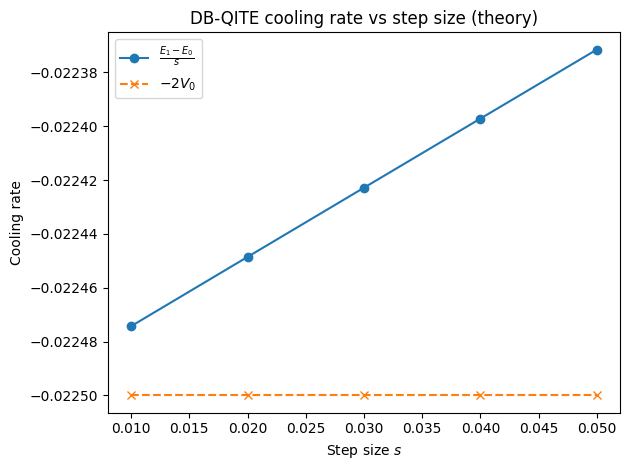

In [14]:
# Step-size scan range
S_MIN = 0.01
S_MAX = 0.05
N_S_POINTS = 5

s_values = np.linspace(S_MIN, S_MAX, N_S_POINTS)
psi0 = Ry(THETA_INIT) @ psi_zero

E0 = np.zeros_like(s_values)
E1 = np.zeros_like(s_values)
V0 = np.zeros_like(s_values)

for i, s in enumerate(s_values):
    Es, Vs, Fs, _ = simulate_dbqite_single_qubit(
        DELTA_A, OMEGA_A, [s], psi0,
        method=DBQITE_METHOD, return_states=True
    )
    E0[i] = Es[0]
    E1[i] = Es[1]
    V0[i] = Vs[0]

cooling_rate = (E1 - E0) / s_values
minus_2V0 = -2.0 * V0

plt.figure()
plt.plot(s_values, cooling_rate, marker="o", label=r"$\frac{E_1 - E_0}{s}$")
plt.plot(s_values, minus_2V0, marker="x", linestyle="--", label=r"$-2V_0$")
plt.xlabel("Step size $s$")
plt.ylabel("Cooling rate")
plt.title("DB-QITE cooling rate vs step size (theory)")
plt.legend()
plt.tight_layout()

### Figure 3: Dependence on initial fidelity: cold-start vs warm-start DB-QITE convergence

To study how DB-QITE convergence depends on the initial overlap with the ground state, we compare a **cold start**
$\lvert\psi_0^{\mathrm{cold}}\rangle=\lvert 0\rangle$ to a **warm start**
$\lvert\psi_0^{\mathrm{warm}}\rangle = R_y(\theta_{\mathrm{warm}})\lvert 0\rangle$ with a controlled initial fidelity.

We first construct the single-qubit Hamiltonian $H(\Delta,\Omega)$ and compute its ground state $\lvert\psi_{\mathrm{gs}}\rangle$.
We then scan $\theta\in[0,\pi]$ and choose $\theta_{\mathrm{warm}}$ such that the initial ground-state fidelity
$$
F_0=\big|\langle \psi_{\mathrm{gs}} \mid R_y(\theta)\lvert 0\rangle\big|^2
$$
is **as large as possible while remaining below a target threshold** (here $F_0 \le 0.6$). This produces a “partially warm”
initialization that is better than the cold start but not already close to the ground state.

Starting from each initial state, we run DB-QITE for $k=0,\dots,N_{\mathrm{steps}}$ using a fixed step size $s=S_{\mathrm{conv}}$,
and record the ground-state fidelity sequence ${F_k}$ returned by the simulator. Finally, we plot $F_k$ versus the DB-QITE step
$k$ for both cold and warm starts to visualize how increased initial fidelity accelerates convergence toward the ground state.


In [15]:
H = make_H(DELTA_A, OMEGA_A)
_, psi_gs = ground_state(H)

thetas = np.linspace(0, np.pi, 2001)
best = (-1, None)
for th in thetas:
    psi = Ry(th) @ psi_zero
    F0 = np.abs(np.vdot(psi_gs, psi))**2
    if F0 > best[0] and F0 <= 0.6:
        best = (F0, th)

print("best F0:", best[0], "best theta:", best[1])
THETA_WARM = best[1]


best F0: 0.5992390777311593 best theta: 2.3813272314210634


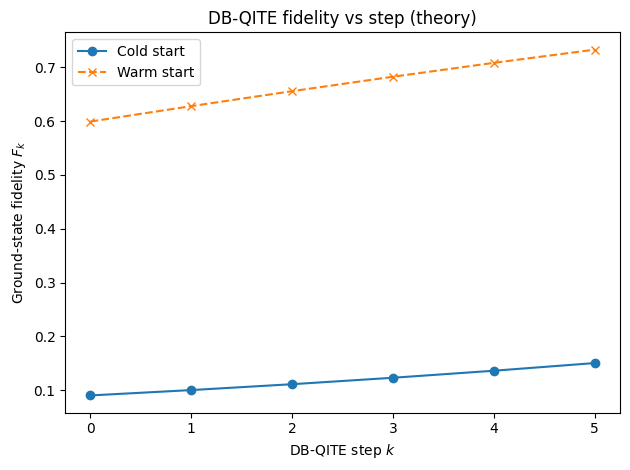

In [16]:
s_list = [S_CONV] * N_STEPS_CONV

psi_cold = psi_zero.copy()
psi_warm = Ry(THETA_WARM) @ psi_zero

Es_cold, Vs_cold, Fs_cold, _ = simulate_dbqite_single_qubit(
    DELTA_A, OMEGA_A, s_list, psi_cold,
    method=DBQITE_METHOD, return_states=True
)
Es_warm, Vs_warm, Fs_warm, _ = simulate_dbqite_single_qubit(
    DELTA_A, OMEGA_A, s_list, psi_warm,
    method=DBQITE_METHOD, return_states=True
)

ks = np.arange(len(Fs_cold))  # 0..N_STEPS_CONV

plt.figure()
plt.plot(ks, Fs_cold, marker="o", label="Cold start")
plt.plot(ks, Fs_warm, marker="x", linestyle="--", label="Warm start")
plt.xlabel("DB-QITE step $k$")
plt.ylabel("Ground-state fidelity $F_k$")
plt.title("DB-QITE fidelity vs step (theory)")
plt.legend()
plt.tight_layout()


### Figure 4: Dependence on initial fidelity: cold-start vs warm-start energy convergence

This figure mirrors Fig. 3, but tracks **energy** instead of fidelity. Using the same fixed step size $s=S_{\mathrm{conv}}$ and the same cold/warm initial states, we record the energy sequence ${E_k}$ over DB-QITE steps $k=0,\dots,N_{\mathrm{steps}}$. For reference, we compute the exact ground-state energy $E_{\mathrm{gs}}$ from $H(\Delta,\Omega)$ and plot it as a horizontal line. We then compare how quickly $E_k$ approaches $E_{\mathrm{gs}}$ for cold vs warm starts.


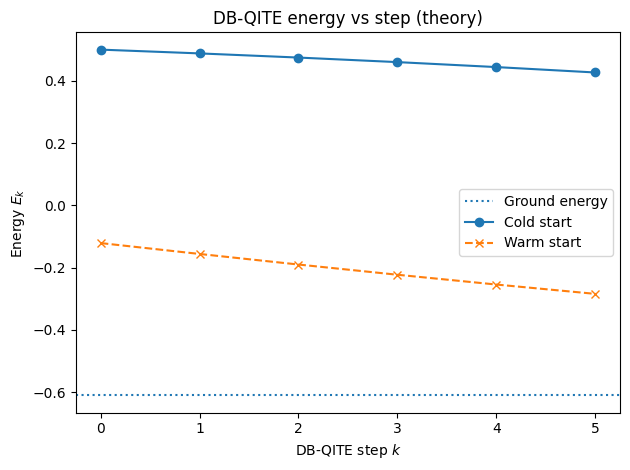

In [17]:
s_list = [S_CONV] * N_STEPS_CONV

psi_cold = psi_zero.copy()
psi_warm = Ry(THETA_WARM) @ psi_zero

Es_cold, Vs_cold, Fs_cold, _ = simulate_dbqite_single_qubit(
    DELTA_A, OMEGA_A, s_list, psi_cold,
    method=DBQITE_METHOD, return_states=True
)
Es_warm, Vs_warm, Fs_warm, _ = simulate_dbqite_single_qubit(
    DELTA_A, OMEGA_A, s_list, psi_warm,
    method=DBQITE_METHOD, return_states=True
)

ks = np.arange(len(Es_cold))  # 0..N_STEPS_CONV

H = make_H(DELTA_A, OMEGA_A)
evals = np.linalg.eigvalsh(H)
Egs = evals.min()

plt.figure()
plt.axhline(Egs, linestyle=":", label="Ground energy")
plt.plot(ks, Es_cold, marker="o", label="Cold start")
plt.plot(ks, Es_warm, marker="x", linestyle="--", label="Warm start")
plt.xlabel("DB-QITE step $k$")
plt.ylabel("Energy $E_k$")
plt.title("DB-QITE energy vs step (theory)")
plt.legend()
plt.tight_layout()

### Figure 5: Fidelity gain vs initial fidelity: one-step DB-QITE improvement

To quantify how much a **single** DB-QITE step improves the ground-state overlap as a function of the starting point, we sweep the initial rotation angle $\theta \in [\theta_{\min},\theta_{\max}]$ and prepare
$\lvert\psi_0\rangle = R_y(\theta)\lvert 0\rangle$, spanning a range of initial fidelities
$F_0 = |\langle \psi_{\mathrm{gs}} \mid \psi_0\rangle|^2$ with the exact ground state $\lvert\psi_{\mathrm{gs}}\rangle$.

For each initial state, we run **one** DB-QITE iteration with fixed step size $s=S_{\mathrm{gap}}$ and record the fidelity before and after the update, $F_0$ and $F_1$. We then compute the one-step fidelity gain
$$
\Delta F = F_1 - F_0,
$$
and plot $\Delta F$ versus $F_0$ to reveal where DB-QITE provides the largest incremental improvement depending on the starting fidelity.


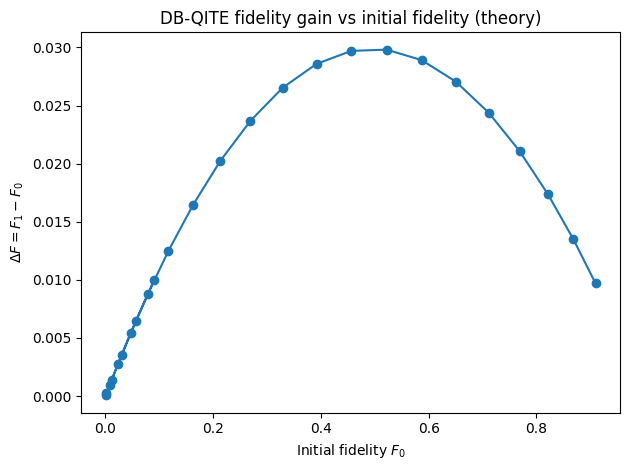

In [18]:
theta_values = np.linspace(THETA_MIN, THETA_MAX, N_THETA_POINTS)
H = make_H(DELTA_A, OMEGA_A)
_, psi_gs = ground_state(H)

F0 = np.zeros_like(theta_values)
F1 = np.zeros_like(theta_values)

for i, th in enumerate(theta_values):
    psi0 = Ry(th) @ psi_zero
    Es, Vs, Fs, _ = simulate_dbqite_single_qubit(
        DELTA_A, OMEGA_A, [S_GAP], psi0,
        method=DBQITE_METHOD, return_states=True
    )
    # Fs already uses ground state internally, but we just take it:
    F0[i] = Fs[0]
    F1[i] = Fs[1]

deltaF = F1 - F0

plt.figure()
plt.plot(F0, deltaF, marker="o")
plt.xlabel(r"Initial fidelity $F_0$")
plt.ylabel(r"$\Delta F = F_1 - F_0$")
plt.title("DB-QITE fidelity gain vs initial fidelity (theory)")
plt.tight_layout()